In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from warnings import filterwarnings
filterwarnings("ignore")

product_catalog = pd.read_csv("data/product_catalog.csv")
product_category = pd.read_csv("data/product_category_map.csv")
transactions = pd.read_csv("data/transactions.csv")

In [2]:
import seaborn as sns

# Data Review and Analysis Part

In [3]:
product_catalog.head()

,product_id,manufacturer_id,attribute_1,attribute_2,attribute_3,attribute_4,attribute_5,categories
0,22665,861,4,0,490,2,66,"[2890, 855, 3908, 3909]"
1,28640,1366,10,1,537,0,101,NaN
2,13526,1090,10,0,511,0,0,"[3270, 163, 284, 1694, 12, 3837, 2422, 3595, 3..."
3,21399,1090,10,1,511,0,0,[3270]
4,8504,768,4,1,484,0,66,[2470]


In [4]:
product_category.head()

,category_id,parent_category_id
0,0,75
1,1,1499
2,2,1082
3,3,3498
4,4,1623


In [5]:
transactions.head()

,customer_id,product_id,purchase_date,quantity
0,38769,3477,2020-06-01,1
1,42535,30474,2020-06-01,1
2,42535,15833,2020-06-01,1
3,42535,20131,2020-06-01,1
4,42535,4325,2020-06-01,1


In [6]:
product_catalog.info()
print("\n")
transactions.info()
print("\n")
product_category.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32776 entries, 0 to 32775
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   product_id       32776 non-null  int64 
 1   manufacturer_id  32776 non-null  int64 
 2   attribute_1      32776 non-null  int64 
 3   attribute_2      32776 non-null  int64 
 4   attribute_3      32776 non-null  int64 
 5   attribute_4      32776 non-null  int64 
 6   attribute_5      32776 non-null  int64 
 7   categories       25988 non-null  object
dtypes: int64(7), object(1)
memory usage: 2.0+ MB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1071538 entries, 0 to 1071537
Data columns (total 4 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   customer_id    1071538 non-null  int64 
 1   product_id     1071538 non-null  int64 
 2   purchase_date  1071538 non-null  object
 3   quantity       1071538 non-null  int64 
dtypes: 

Assigning categories based on similarity with other products

In [7]:
from sklearn.metrics.pairwise import euclidean_distances
import numpy as np

numerical_features = ["manufacturer_id", "attribute_1", "attribute_2", "attribute_3", "attribute_4", "attribute_5"]

missing_categories = product_catalog[product_catalog["categories"].isnull()]
filled_categories = product_catalog[~product_catalog["categories"].isnull()]


def find_closest_category(row, filled_df, features):
    row_features = row[features].values.reshape(1, -1)
    
    filled_features = filled_df[features].values
    distances = euclidean_distances(row_features, filled_features)
    
    best_match_idx = np.argmin(distances)
    return filled_df.iloc[best_match_idx]["categories"]

missing_categories["categories"] = missing_categories.apply(
    lambda row: find_closest_category(row, filled_categories, numerical_features), axis=1
)

product_catalog_updated = pd.concat([filled_categories, missing_categories])

print(product_catalog_updated["categories"].isnull().sum())

0


In [8]:
product_catalog_updated.reset_index(drop=True, inplace=True)

In [9]:
product_catalog_updated.head()

,product_id,manufacturer_id,attribute_1,attribute_2,attribute_3,attribute_4,attribute_5,categories
0,22665,861,4,0,490,2,66,"[2890, 855, 3908, 3909]"
1,13526,1090,10,0,511,0,0,"[3270, 163, 284, 1694, 12, 3837, 2422, 3595, 3..."
2,21399,1090,10,1,511,0,0,[3270]
3,8504,768,4,1,484,0,66,[2470]
4,31956,1388,4,0,491,0,66,"[236, 3625, 356]"


In [10]:
#Merge product_catalog_updated with transactions
product_transactions = pd.merge(transactions, product_catalog_updated, on="product_id", how="left")

In [11]:
product_transactions.head()

,customer_id,product_id,purchase_date,quantity,manufacturer_id,attribute_1,attribute_2,attribute_3,attribute_4,attribute_5,categories
0,38769,3477,2020-06-01,1,186,6,0,196,0,45,"[74, 4109, 3867, 803, 4053]"
1,42535,30474,2020-06-01,1,193,10,3,229,3,132,"[3459, 3738, 679, 1628, 4072]"
2,42535,15833,2020-06-01,1,1318,4,1,455,0,108,"[2973, 2907, 2749, 3357]"
3,42535,20131,2020-06-01,1,347,4,0,291,3,44,"[30, 1515, 1760, 2932, 1287, 2615, 3727, 2450,..."
4,42535,4325,2020-06-01,1,539,6,0,303,0,45,"[3104, 1772, 2029, 1274, 3915, 888, 1118, 3882..."


# EDA Part

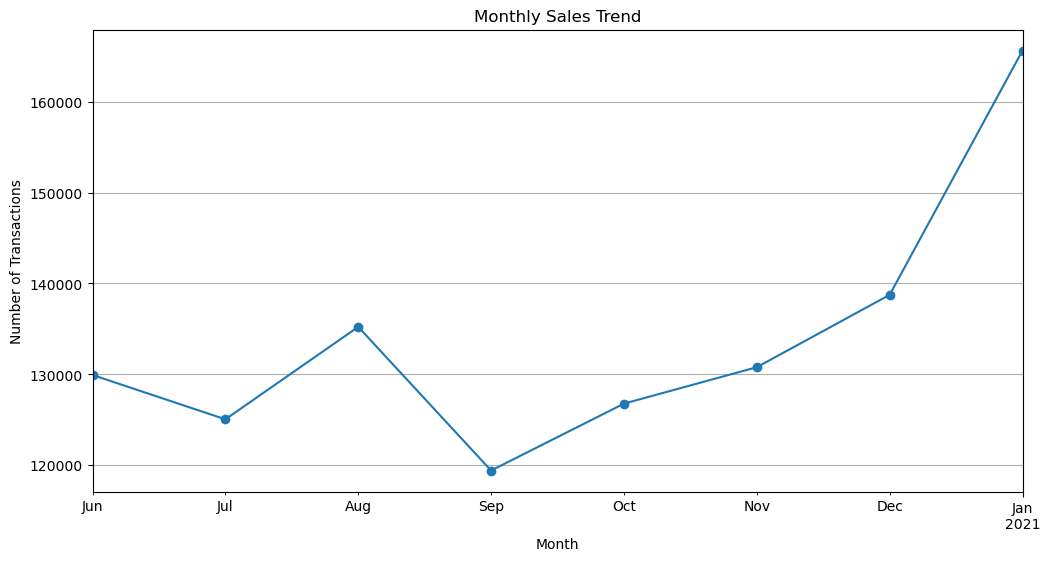

In [12]:
product_transactions["purchase_date"] = pd.to_datetime(product_transactions["purchase_date"])
sales_trend = product_transactions.groupby(product_transactions["purchase_date"].dt.to_period("M")).size()

plt.figure(figsize=(12, 6))
sales_trend.plot(kind="line", marker="o", title="Monthly Sales Trend")
plt.xlabel("Month")
plt.ylabel("Number of Transactions")
plt.grid()
plt.show()

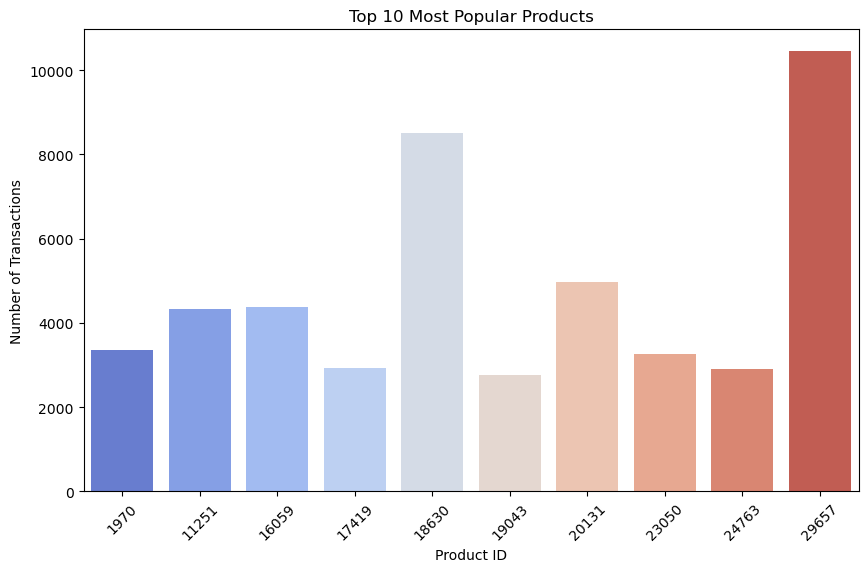

In [13]:
product_popularity = product_transactions["product_id"].value_counts().head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=product_popularity.index, y=product_popularity.values, palette="coolwarm")
plt.title("Top 10 Most Popular Products")
plt.xlabel("Product ID")
plt.ylabel("Number of Transactions")
plt.xticks(rotation=45)
plt.show()

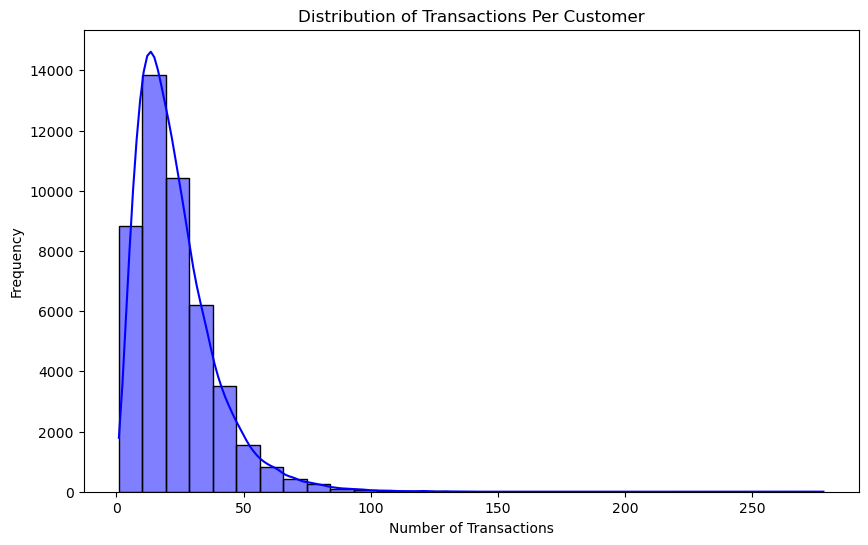

In [14]:
customer_purchases = product_transactions["customer_id"].value_counts()

plt.figure(figsize=(10, 6))
sns.histplot(customer_purchases, bins=30, kde=True, color="blue")
plt.title("Distribution of Transactions Per Customer")
plt.xlabel("Number of Transactions")
plt.ylabel("Frequency")
plt.show()

# Feature Engineering Part

In [15]:
customer_total_purchases = product_transactions.groupby("customer_id")["quantity"].sum().reset_index()
customer_total_purchases.rename(columns={"quantity": "total_purchases"}, inplace=True)

In [16]:
product_popularity = product_transactions.groupby("product_id")["quantity"].sum().reset_index()
product_popularity.rename(columns={"quantity": "product_popularity"}, inplace=True)

In [17]:
product_transactions["month"] = product_transactions["purchase_date"].dt.month
product_transactions["week"] = product_transactions["purchase_date"].dt.isocalendar().week

In [18]:
product_transactions = pd.merge(product_transactions, customer_total_purchases, on="customer_id", how="left")
product_transactions = pd.merge(product_transactions, product_popularity, on="product_id", how="left")

In [19]:
product_transactions.head()

,customer_id,product_id,purchase_date,quantity,manufacturer_id,attribute_1,attribute_2,attribute_3,attribute_4,attribute_5,categories,month,week,total_purchases,product_popularity
0,38769,3477,2020-06-01,1,186,6,0,196,0,45,"[74, 4109, 3867, 803, 4053]",6,23,118,617
1,42535,30474,2020-06-01,1,193,10,3,229,3,132,"[3459, 3738, 679, 1628, 4072]",6,23,25,577
2,42535,15833,2020-06-01,1,1318,4,1,455,0,108,"[2973, 2907, 2749, 3357]",6,23,25,9
3,42535,20131,2020-06-01,1,347,4,0,291,3,44,"[30, 1515, 1760, 2932, 1287, 2615, 3727, 2450,...",6,23,25,8061
4,42535,4325,2020-06-01,1,539,6,0,303,0,45,"[3104, 1772, 2029, 1274, 3915, 888, 1118, 3882...",6,23,25,1336
